# Smart Food Image Generator - Solution

[View on Google Colab](https://colab.research.google.com/drive/1-FkOtXknlFua8u3W30I9J68MBTnOaQf4?usp=sharing)

Week 8: Multimodal AI for Food Delivery Business

This solution shows how to generate food images and analyze them for safety
using Stable Diffusion and BLIP models.

### Import the necessary libraries

In [1]:
import torch
import matplotlib.pyplot as plt
from PIL import Image
from diffusers import StableDiffusionPipeline
from transformers import BlipProcessor, BlipForQuestionAnswering

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")

In [2]:
def setup_device():
    """
    Setup device for optimal performance
    
    SOLUTION: Check for available hardware and return appropriate device and data type.
    """
    if torch.cuda.is_available():
        return "cuda", torch.float16
    elif torch.backends.mps.is_available():
        return "mps", torch.float32
    else:
        return "cpu", torch.float32

# TEST: Setup device
print("🔧 TESTING: Setting up device...")
device, dtype = setup_device()
print(f"Using device: {device}")

🔧 TESTING: Setting up device...
Using device: mps


---

### Load Models from HuggingFace

In [3]:
def load_models(device, dtype):
    """
    Load all required models for food generation and analysis
    
    SOLUTION: We load Stable Diffusion for image generation and BLIP for food analysis.
    """
    print("📦 Loading models...")
    
    # Load Stable Diffusion for food image generation
    text2img_pipe = StableDiffusionPipeline.from_pretrained(
            "runwayml/stable-diffusion-v1-5",
            torch_dtype=dtype,
            safety_checker=None,
            requires_safety_checker=False
        )
    text2img_pipe = text2img_pipe.to(device)
    
    # Load BLIP for food analysis
    blip_model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base")
    blip_processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
    blip_model.eval()
    
    print("✅ All models loaded successfully!")
    return text2img_pipe, blip_model, blip_processor

# TEST: Load models
print("📦 TESTING: Loading models...")
text2img_pipe, blip_model, blip_processor = load_models(device, dtype)

📦 TESTING: Loading models...
📦 Loading models...


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


✅ All models loaded successfully!


---

### Generate Food Image

🍽️ TESTING: Generating food image...
🍽️ Generating: butter chicken with rice


  0%|          | 0/20 [00:00<?, ?it/s]

✅ Food image generated!


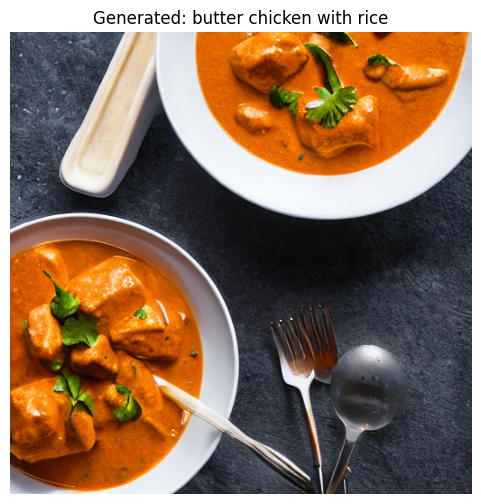

In [4]:
def generate_food_image(food_description, seed=42):
    """
    Generate professional food image from text description
    
    SOLUTION: We enhance the prompt with food photography terms and use Stable Diffusion.
    """
    print(f"🍽️ Generating: {food_description}")
        
        # Enhanced prompt for better food photography
    prompt = f"{food_description}, professional food photography, appetizing, restaurant style"
        
    # Set seed for reproducible results
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        
    # Generate image
    with torch.no_grad():
        result = text2img_pipe(
            prompt=prompt,
            negative_prompt="blurry, low quality, unappetizing",
                num_inference_steps=20,
                guidance_scale=7.5,
                height=512,
                width=512
            )
        
    print("✅ Food image generated!")
    return result.images[0]

# TEST: Generate food image
print("🍽️ TESTING: Generating food image...")
test_food = "butter chicken with rice"
food_image = generate_food_image(test_food)

# Display the image
plt.figure(figsize=(6, 6))
plt.imshow(food_image)
plt.title(f"Generated: {test_food}")
plt.axis('off')
plt.show()
print()

---

### Question Answering about Food

In [5]:
def ask_about_food(image, question):
    """
    Ask questions about food using BLIP VQA
    
    SOLUTION: We use BLIP to analyze food images and answer questions about them.
    """
    # Process image and question
    inputs = blip_processor(image, question, return_tensors="pt")
    
    # Generate answer
    with torch.no_grad():
        out = blip_model.generate(**inputs, max_length=50, num_beams=5)
    
    # Decode answer
    answer = blip_processor.decode(out[0], skip_special_tokens=True)
    return answer.strip()

# TEST: Ask questions about food
print("❓ TESTING: Asking questions about food...")
questions = [
    "What type of food is this?",
    "Does this contain dairy?",
    "Is this food spicy?"
]

for question in questions:
    answer = ask_about_food(food_image, question)
    print(f"Q: {question}")
    print(f"A: {answer}")

❓ TESTING: Asking questions about food...
Q: What type of food is this?
A: soup
Q: Does this contain dairy?
A: no
Q: Is this food spicy?
A: yes


---

### Analyze Food Safety

In [6]:
def analyze_food_safety(food_image):
    """
    Analyze food for ingredients and allergens
    
    SOLUTION: We ask specific questions to detect ingredients and common allergens.
    """
    print("🔬 Analyzing food safety...")
    
    # Get basic info
    description = ask_about_food(food_image, "Describe the food")
    
    # Check for common allergens
    allergen_questions = [
        "Does this contain dairy or milk?",
        "Does this contain nuts?", 
        "Does this contain eggs?",
        "Does this contain wheat or gluten?"
    ]
    
    allergens = []
    for question in allergen_questions:
        answer = ask_about_food(food_image, question)
        if "yes" in answer.lower():
            allergen = question.split("contain ")[-1].split("?")[0]
            allergens.append(allergen)
    
    # Get dietary info
    vegetarian = ask_about_food(food_image, "Is this vegetarian?")
    spicy = ask_about_food(food_image, "Is this spicy?")
    
    analysis = {
        "description": description,
        "allergens": allergens,
        "vegetarian": vegetarian,
        "spicy": spicy
    }
    
    print("✅ Food analysis complete!")
    return analysis

# TEST: Analyze food safety
print("🔬 TESTING: Food safety analysis...")
analysis = analyze_food_safety(food_image)

print("Analysis Results:")
print(f"Description: {analysis['description']}")
print(f"Allergens: {', '.join(analysis['allergens']) if analysis['allergens'] else 'None detected'}")
print(f"Vegetarian: {analysis['vegetarian']}")
print(f"Spicy: {analysis['spicy']}")

🔬 TESTING: Food safety analysis...
🔬 Analyzing food safety...
✅ Food analysis complete!
Analysis Results:
Description: soup
Allergens: None detected
Vegetarian: no
Spicy: yes


---

### Generate and Analyze Food

🚀 TESTING: Complete pipeline...

--- Testing: chocolate chip cookies ---
🚀 Complete pipeline for: chocolate chip cookies
🍽️ Generating: chocolate chip cookies


  0%|          | 0/20 [00:00<?, ?it/s]

✅ Food image generated!
🔬 Analyzing food safety...
✅ Food analysis complete!


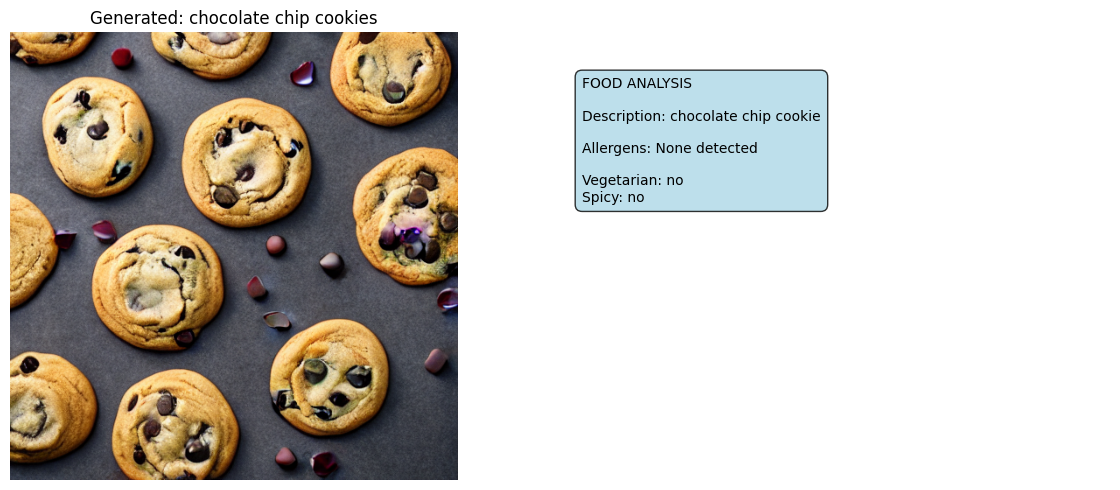



--- Testing: grilled salmon with vegetables ---
🚀 Complete pipeline for: grilled salmon with vegetables
🍽️ Generating: grilled salmon with vegetables


  0%|          | 0/20 [00:00<?, ?it/s]

✅ Food image generated!
🔬 Analyzing food safety...
✅ Food analysis complete!


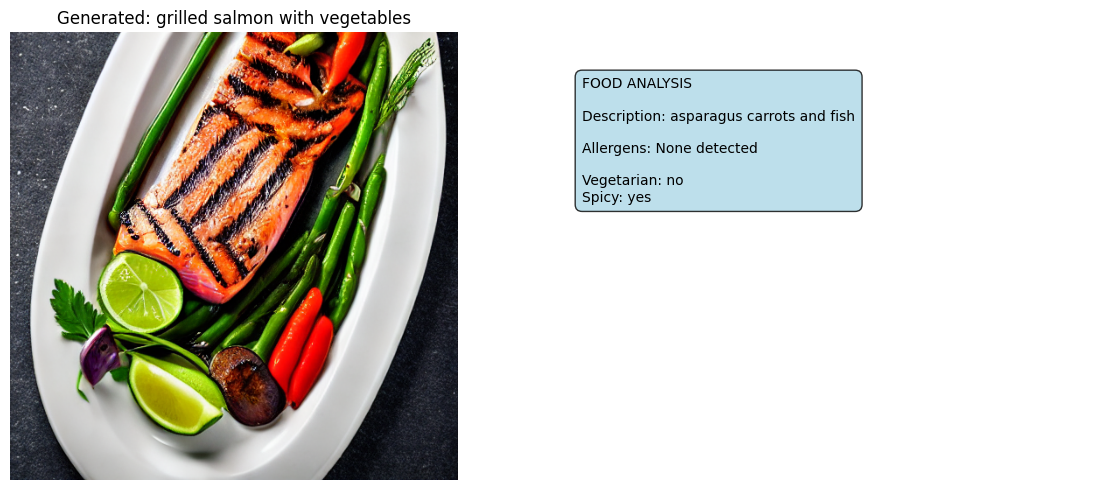

In [7]:
def generate_and_analyze_food(food_description):
    """
    Complete pipeline: generate food image and analyze it
    
    SOLUTION: This combines image generation with safety analysis for food delivery apps.
    """
    print(f"🚀 Complete pipeline for: {food_description}")
    
    # Generate food image
    food_image = generate_food_image(food_description)
    
    # Analyze the food
    analysis = analyze_food_safety(food_image)
    
    # Display results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Show image
    ax1.imshow(food_image)
    ax1.set_title(f"Generated: {food_description}")
    ax1.axis('off')
    
    # Show analysis
    ax2.axis('off')
    analysis_text = f"FOOD ANALYSIS\n\n"
    analysis_text += f"Description: {analysis['description']}\n\n"
    analysis_text += f"Allergens: {', '.join(analysis['allergens']) if analysis['allergens'] else 'None detected'}\n\n"
    analysis_text += f"Vegetarian: {analysis['vegetarian']}\n"
    analysis_text += f"Spicy: {analysis['spicy']}"
    
    ax2.text(0.1, 0.9, analysis_text, transform=ax2.transAxes, 
             fontsize=10, verticalalignment='top',
             bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    return food_image, analysis

# TEST: Complete pipeline
print("🚀 TESTING: Complete pipeline...")
test_foods = [
    "chocolate chip cookies",
    "grilled salmon with vegetables"
]

for food in test_foods:
    print(f"\n--- Testing: {food} ---")
    img, result = generate_and_analyze_food(food)
    print()

---